# Heart Disease Data Analysis

In [20]:
#importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer,OneHotEncoder, StandardScaler, normalize
from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from scipy import stats
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import RocCurveDisplay
 
%matplotlib inline

# Uploading Data and Understanding Data

Data Information

1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

In [3]:
#uploading the document
df=pd.read_csv('../../heart.csv')

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [6]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [7]:
df.shape

(918, 12)

In [8]:
df.HeartDisease.value_counts(normalize=True)

HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64

In [9]:
#checking if we have duplicated data
#we dont have duplicated data
duplicates= df[df.duplicated()]
print(len(duplicates))

0


In [10]:
#checking if we have NaN Values
#we dont have null values
null_values=df.isna().sum()
null_values

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

# Data Analysis

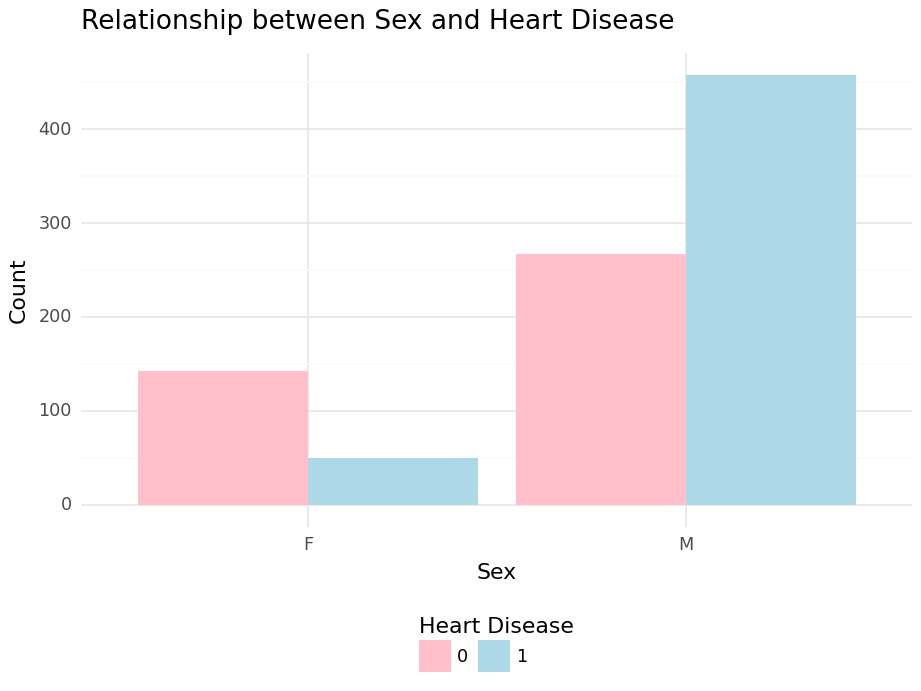

<Figure Size: (460 x 345)>

In [11]:
def plotting(df, column):
     return (p9.ggplot(df, p9.aes(x=column, fill='factor(HeartDisease)')) + 
             p9.geom_bar(position='dodge') + 
             p9.labs(title=f'Relationship between {column} and Heart Disease', 
                     x=column, y='Count', fill='Heart Disease') +
             p9.theme(axis_text_x=p9.element_text(angle=45, hjust=1)) + 
             p9.scale_fill_manual(values=['#FFC0CB', '#ADD8E6']) + 
             p9.theme_minimal() + p9.theme(legend_position='bottom')) 
    
plotting(df, 'Sex')

# Model Transformation

In [12]:
#Definig the features and the target variable
y=df['HeartDisease']
X=df.drop(columns=['HeartDisease'],axis=1)
X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up


In [13]:
#Splitting the data into test and training sets
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=11)

In [14]:
def data_preparation(X_train):
    """
    Input: A set of Data
    Output: Return a standarized data frame where all categorical columns have been changed to numerical 
    
    """
    # Define numerical and categorical columns
    numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']
    categorical_columns = ['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope', 'RestingECG']

    # Create a column transformer
    col_transformer = ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore"), categorical_columns)
    ], remainder="passthrough")

    # Create a pipeline containing the single column transformer
    pipe = Pipeline(steps=[
    ("col_transformer",col_transformer),
    ("scale", StandardScaler())
    ])

    # Use the pipeline to fit and transform the data
    transformed_data = pipe.fit_transform(X_train)

    # Extract the category labels from the OHE within the pipeline
    encoder = col_transformer.named_transformers_["ohe"]
    category_labels = encoder.get_feature_names(categorical_columns)

    # Combine category labels with numerical columns
    column_names = np.append(category_labels, numerical_columns)

    # Make a dataframe with the relevant columns and rename columns
    transformed_df = pd.DataFrame(transformed_data, columns=column_names)
    
    #remove the columns that are correlated due to the dummy variable
    transformed_df=transformed_df.drop(columns=['Sex_F', 'ChestPainType_ASY', 'ExerciseAngina_N', 'ST_Slope_Down', 'RestingECG_Normal'], axis=1)

    # Rename one-hot encoded columns with original categorical column names
    return transformed_df

In [15]:
train_df=data_preparation(X_train)
test_df=data_preparation(X_test)
test_df.head()

,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,RestingECG_LVH,RestingECG_ST,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,FastingBS
0,0.543852,1.993232,-0.484664,-0.167132,-0.906522,1.0,-0.829502,-0.560612,-0.476095,-1.385627,0.088211,0.080863,-0.510171,-0.109374,-0.750448
1,0.543852,-0.501698,-0.484664,-0.167132,1.103117,-1.0,1.205543,1.783765,-0.476095,-0.285259,0.322083,0.577967,-0.510171,1.910595,-0.750448
2,0.543852,-0.501698,-0.484664,-0.167132,-0.906522,1.0,-0.829502,-0.560612,-0.476095,-1.715738,0.088211,-1.658999,1.960129,0.563949,-0.750448
3,0.543852,-0.501698,2.063284,-0.167132,1.103117,1.0,-0.829502,-0.560612,-0.476095,-1.275590,-0.613407,0.295132,-0.510171,0.638763,0.617607
4,0.543852,-0.501698,-0.484664,-0.167132,-0.906522,1.0,-0.829502,-0.560612,-0.476095,1.475331,-0.379535,0.517971,1.960129,1.050238,-0.568040


# Logistic Regression Model

# Hyperparameter Tuning

In [21]:
#creating parameters for randomize search
random_params ={'C': np.logspace(-5,5,25),
                'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

np.random.seed(100)

In [22]:
# Define our random search for parameter tuning
randomsearch = RandomizedSearchCV(LogisticRegression(),
                                  param_distributions=random_params, 
                                  scoring='accuracy', 
                                  cv=5,
                                  n_iter=20,
                                  verbose=True)

In [23]:
#fitting the data
randomsearch.fit(train_df, y_train)
randomsearch.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\hinapatel\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hinapatel\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hinapatel\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\hinapatel\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 433, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
Value

{'solver': 'newton-cg', 'C': 5623.413251903491}

In [24]:
#evaluating the best model
randomsearch.score(test_df, y_test)

0.8206521739130435

# Feature Selection

In [26]:
#creating and fitting the model
model_0=LogisticRegression(solver='newton-cg', C= 0.00825404185268019)
model_0.fit(train_df, y_train)

LogisticRegression(C=0.00825404185268019, solver='newton-cg')

In [28]:
#checking the coefficients correlation with terms of the target
#matching our coefficients to the feature columns
features_dict=dict(zip(train_df.columns, list(model_0.coef_[0])))
features_dict

{'Sex_M': 0.24430450429205694,
 'ChestPainType_ATA': -0.2935475588303294,
 'ChestPainType_NAP': -0.2395220972520134,
 'ChestPainType_TA': -0.09488730524206614,
 'ExerciseAngina_Y': 0.32257325824077804,
 'ST_Slope_Flat': 0.3671299341600438,
 'ST_Slope_Up': -0.3697820690997368,
 'RestingECG_LVH': 0.03325028512325698,
 'RestingECG_ST': 0.05696955078529585,
 'Age': 0.10972493122340922,
 'RestingBP': 0.023631121852034986,
 'Cholesterol': -0.178292615644295,
 'MaxHR': 0.20747088113419507,
 'Oldpeak': -0.2037607178149126,
 'FastingBS': 0.26030368871484305}

In [30]:
#using the model but only with the selected features. 
#We select feature only having where the abs value is 0.25 or above.
feature_importance_train=train_df.drop(columns=['RestingECG_LVH','RestingECG_ST','Age','RestingBP','Cholesterol'])
feature_importance_test=test_df.drop(columns=['RestingECG_LVH','RestingECG_ST','Age','RestingBP','Cholesterol'])
model_1=LogisticRegression(solver='newton-cg', C= 0.00825404185268019)
model_1.fit(feature_importance_train, y_train)

LogisticRegression(C=0.00825404185268019, solver='newton-cg')

# XG Boost Model

# Decision Tree Model

# ROC and AUC Curves 

In [43]:
from sklearn.metrics import roc_curve, auc

In [40]:
!pip upgrade sklearn

ERROR: unknown command "upgrade"



In [32]:
# def roc_auc_calc(X_train, model_log):
#     # Calculate the probability scores of each point in the training set
#     y_train_score = model_log.decision_function(X_train)
    
#     # Calculate the fpr, tpr, and thresholds for the training set
#     train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

#     # Calculate the probability scores of each point in the test set
#     y_score = model_log.decision_function(X_test)

#     # Calculate the fpr, tpr, and thresholds for the test set
#     fpr, tpr, thresholds = roc_curve(y_test, y_score)
#     return fpr, tpr, thresholds

In [35]:
# def roc_auc_calc(X_test, y_test, model):
#      RocCurveDisplay.from_estimator(X_test, y_test, model) 

In [52]:
def roc_auc(X_test, y_test, model):
    y_pred = model.predict_proba(X_test).argmax(axis=1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    display.plot()  
    plt.show()

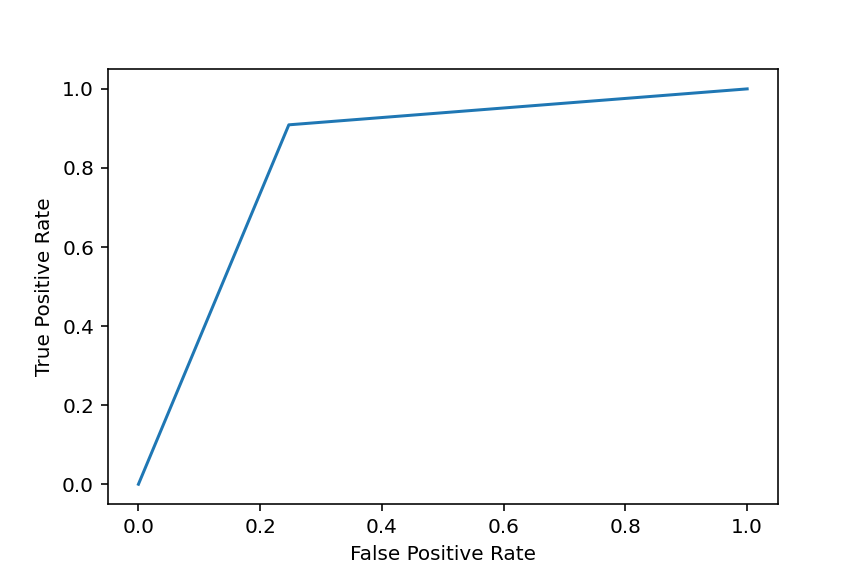

In [53]:
# logistic regression model error analysis
roc_auc(feature_importance_test, y_test, model_1)

In [ ]:
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# ROC curve for test set
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
    plt.legend(loc='lower right')
    print('Test AUC: {}'.format(auc(fpr, tpr)))
    print('')
    plt.show()